nbconvert_config = {'NbConvert': {'export': {'markdown': {} }}}

# Predicting Thyroid Disease using Machine Learning

This notebook introduces some foundational machine learning and data science concepts by exploring the problem of thyroid disease **classification**.

## 1. Problem Definition
This dataset contains 13 clinicopathologic features aiming to predict the recurrence of well-differentiated thyroid cancer. The data was collected over 15 years, and each patient was followed for at least 10 years.

We aim to predict the recurrence of thyroid cancer.

## 2. Data
The data is sourced from [Kaggle](https://www.kaggle.com/datasets/jainaru/thyroid-disease-data).

## 3. Evaluation
Our goal is to achieve 95% accuracy in predicting the recurrence of thyroid cancer.

## 4. Thyroid Disease Dictionary
1. **Age**: The age of the patient at the time of diagnosis or treatment.
2. **Gender**: The gender of the patient.
3. **Smoking**: Whether the patient is a smoker or not.
4. **Hx Smoking**: Smoking history of the patient.
5. **Hx Radiotherapy**: History of radiotherapy treatment for any condition.
6. **Thyroid function**: The status of thyroid function, possibly indicating any abnormalities.
7. **Physical examination**: Findings from a physical examination of the patient, which may include palpation of the thyroid gland and surrounding structures.
8. **Adenopathy**: Presence or absence of enlarged lymph nodes in the neck region.
9. **Pathology**: Specific types of thyroid cancer as determined by pathology examination of biopsy samples.
10. **Focality**: Whether the cancer is unifocal (limited to one location) or multifocal (present in multiple locations).
11. **Risk**: Risk of cancer.
12. **T**: Tumor classification based on the size and extent of invasion into nearby structures.
13. **N**: Nodal classification indicating the involvement of lymph nodes.
14. **M**: Metastasis classification indicating the presence or absence of distant metastases.
15. **Stage**: The overall stage of the cancer.
16. **Response**: Response to treatment, indicating whether the cancer responds positively or remains stable after treatment.
17. **Recurred**: Indicates whether the cancer has recurred after inital treatment (No = 0, Yes = 1).


In [1]:
# Regular EDA and plotting libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # seaborn gets shortened to sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.multiclass import unique_labels

# We want our plots to appear in the notebook
%matplotlib inline 

## Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier


## Model evaluators
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay # new in Scikit-Learn 1.2+
from sklearn.metrics import ConfusionMatrixDisplay

# Print last updated
import time
print(f"Last updated: {time.asctime()}")

Last updated: Sun May 19 02:12:53 2024


## 1. Load data

In [2]:
df = pd.read_csv('D:/UAG/Data-Science-Portfolio/Datasets/Thyroid_diff.csv')
df.head()

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No


## 2. Data Exploration

### 2.1. Gender Analysis of Thyroid Cancer Recurrence

### Visualization
The following graph illustrates the distribution of thyroid cancer recurrence by gender:

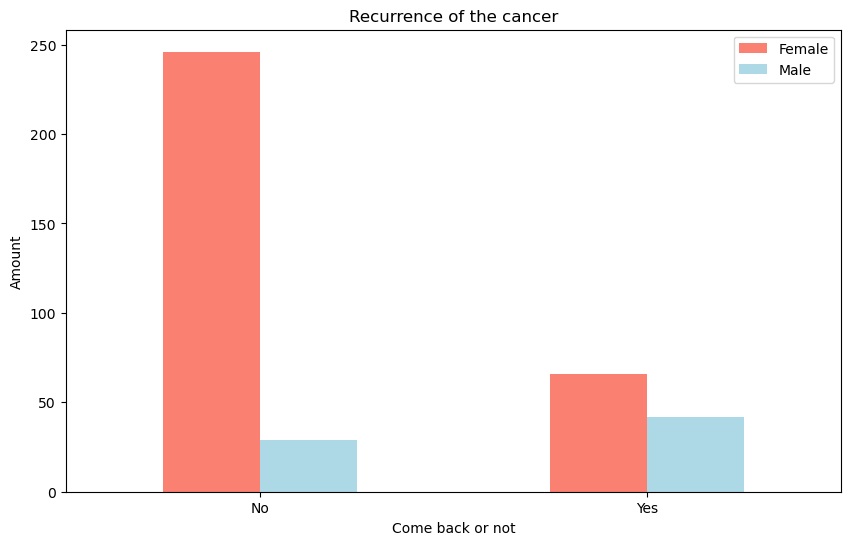

In [3]:
# Create a plot
pd.crosstab(df.Recurred, df.Gender).plot(kind="bar", figsize=(10,6), color=["salmon", "lightblue"])

# Add some attributes to it
plt.title("Recurrence of the cancer")
plt.xlabel("Come back or not")
plt.ylabel("Amount")
plt.legend(["Female", "Male"])
plt.xticks(rotation=0); # keep the labels on the x-axis vertical

> By analyzing the data, we can observe that thyroid cancer recurrence is more prevalent among **female** patients compared to male patients.

### 2.2. Age and Gender Analysis of Thyroid Cancer Recurrence

### Visualization
The following graph illustrates the distribution of thyroid cancer recurrence by age and gender:

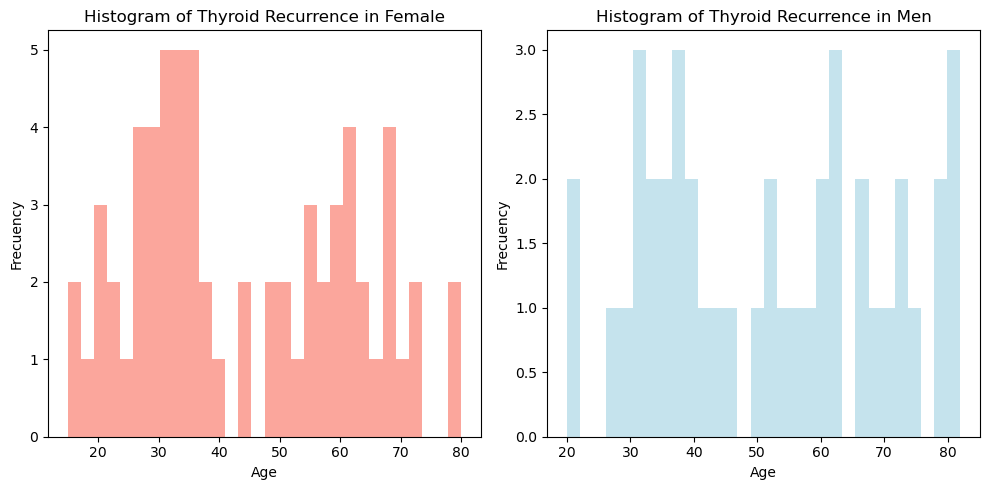

In [4]:
# Filter ages by gender and positive recurrence
edades_f = df[(df['Gender'] == 'F') & (df['Recurred'] == 'Yes')]['Age']
edades_h = df[(df['Gender'] == 'M') & (df['Recurred'] == 'Yes')]['Age']

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(edades_f, bins=30, color='salmon', alpha=0.7)
axs[0].set_title('Histogram of Thyroid Recurrence in Female')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Frecuency')

axs[1].hist(edades_h, bins=30, color='lightblue', alpha=0.7)
axs[1].set_title('Histogram of Thyroid Recurrence in Men')
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Frecuency')

plt.tight_layout()
plt.show()

> In these histograms, we again observe that **women** are more affected by the recurrence of thyroid cancer. Fortunately, the number of recurrences is relatively low. We also notice that age is indistinct, and there is no significant inclination of recurrence among the different age groups, except for a slight increase between 20 and 40 years.

## 2.3. Impact of Smoking on Thyroid Cancer Recurrence

### Visualization
The following graph illustrates the distribution of thyroid cancer recurrence by smoking status and g:d g:

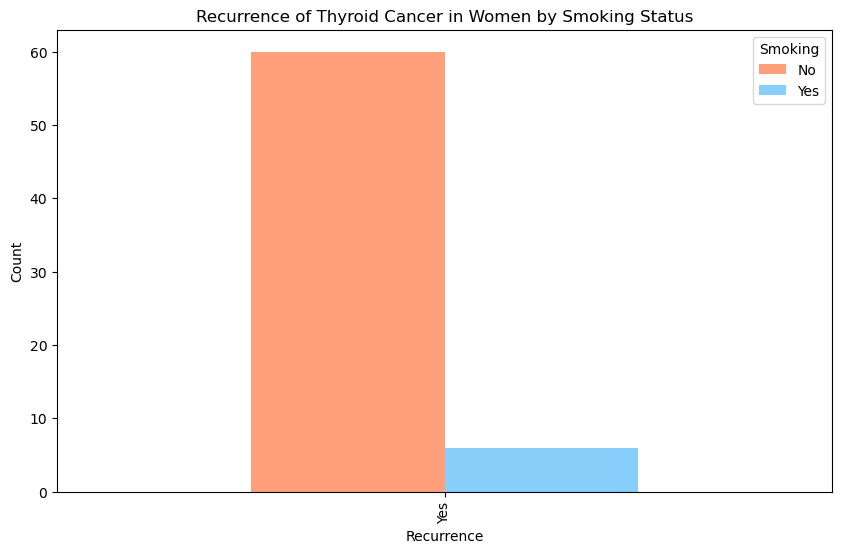

In [5]:
# Filters the DataFrame to obtain only women who have had a recurrence
filtered_df = df[(df['Gender'] == 'F') & (df['Recurred'] == 'Yes')]

# Create a crosstab between recurrence status and smoking
crosstab_result = pd.crosstab(filtered_df['Recurred'], filtered_df['Smoking'])

brick_colors = ["#FFA07A", "#87CEFA"]

# Plot cross table
crosstab_result.plot(kind="bar", figsize=(10, 6),color=brick_colors)

plt.title('Recurrence of Thyroid Cancer in Women by Smoking Status')
plt.xlabel('Recurrence')
plt.ylabel('Count')
plt.show()

> In our analysis, it was observed that smoking does not significantly impact the recurrence of thyroid cancer, particularly among female patients.

### 2.4. Correlation between Smoking and Thyroid Cancer Risk
### Visualization
The following graph illustrates the relationship between smoking status and thyroid cancer incidencece:


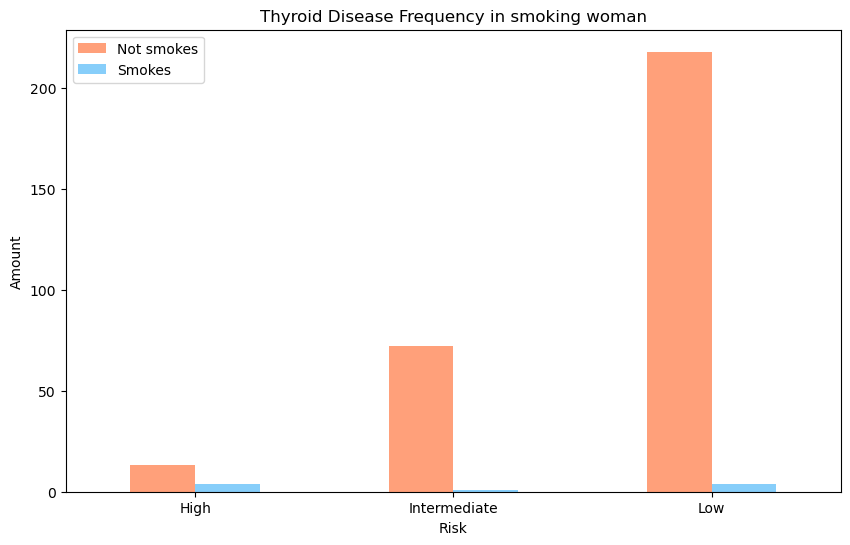

In [6]:
# Filter the risk in women and whether they smoke or not
pd.crosstab(df[df["Gender"] == 'F']['Risk'], df[df["Gender"]== 'F']['Smoking']).plot(kind="bar", figsize=(10,6), color=["#FFA07A", "#87CEFA"])

# Add some attributes to it
plt.title("Thyroid Disease Frequency in smoking woman")
plt.ylabel("Amount")
plt.legend(["Not smokes", "Smokes"])
plt.xticks(rotation=0); # keep the labels on the x-axis vertical

> We can observe that there is no direct relationship between the habit of smoking and the risk of developing thyroid cancer in women.

## 3. Data Proccesing

### 3.1. Handing missing values

In [7]:
df.isnull().sum()

Age                     0
Gender                  0
Smoking                 0
Hx Smoking              0
Hx Radiothreapy         0
Thyroid Function        0
Physical Examination    0
Adenopathy              0
Pathology               0
Focality                0
Risk                    0
T                       0
N                       0
M                       0
Stage                   0
Response                0
Recurred                0
dtype: int64

In [8]:
df.size

6511

> In this dataset, there are no missing values, which simplifies the data preprocessing step

### 3.2. Normalize the age using Min-Max scaling

In [9]:
scaler = MinMaxScaler()
df[['Age']] = scaler.fit_transform(df[['Age']])

### 3.3. Convert string to categories

In [10]:
for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        df[label] = content.astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Age                   383 non-null    float64 
 1   Gender                383 non-null    category
 2   Smoking               383 non-null    category
 3   Hx Smoking            383 non-null    category
 4   Hx Radiothreapy       383 non-null    category
 5   Thyroid Function      383 non-null    category
 6   Physical Examination  383 non-null    category
 7   Adenopathy            383 non-null    category
 8   Pathology             383 non-null    category
 9   Focality              383 non-null    category
 10  Risk                  383 non-null    category
 11  T                     383 non-null    category
 12  N                     383 non-null    category
 13  M                     383 non-null    category
 14  Stage                 383 non-null    category
 15  Respon

### 3.4. Codifying categorical variables

In [11]:
for label, content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        df[label] = pd.Categorical(content).codes

### 3.5. Correlation matrix
> Now that we have encoded our categorical variables, we can generate a correlation matrix to identify the impact that independent variables have on the dependent variable. 

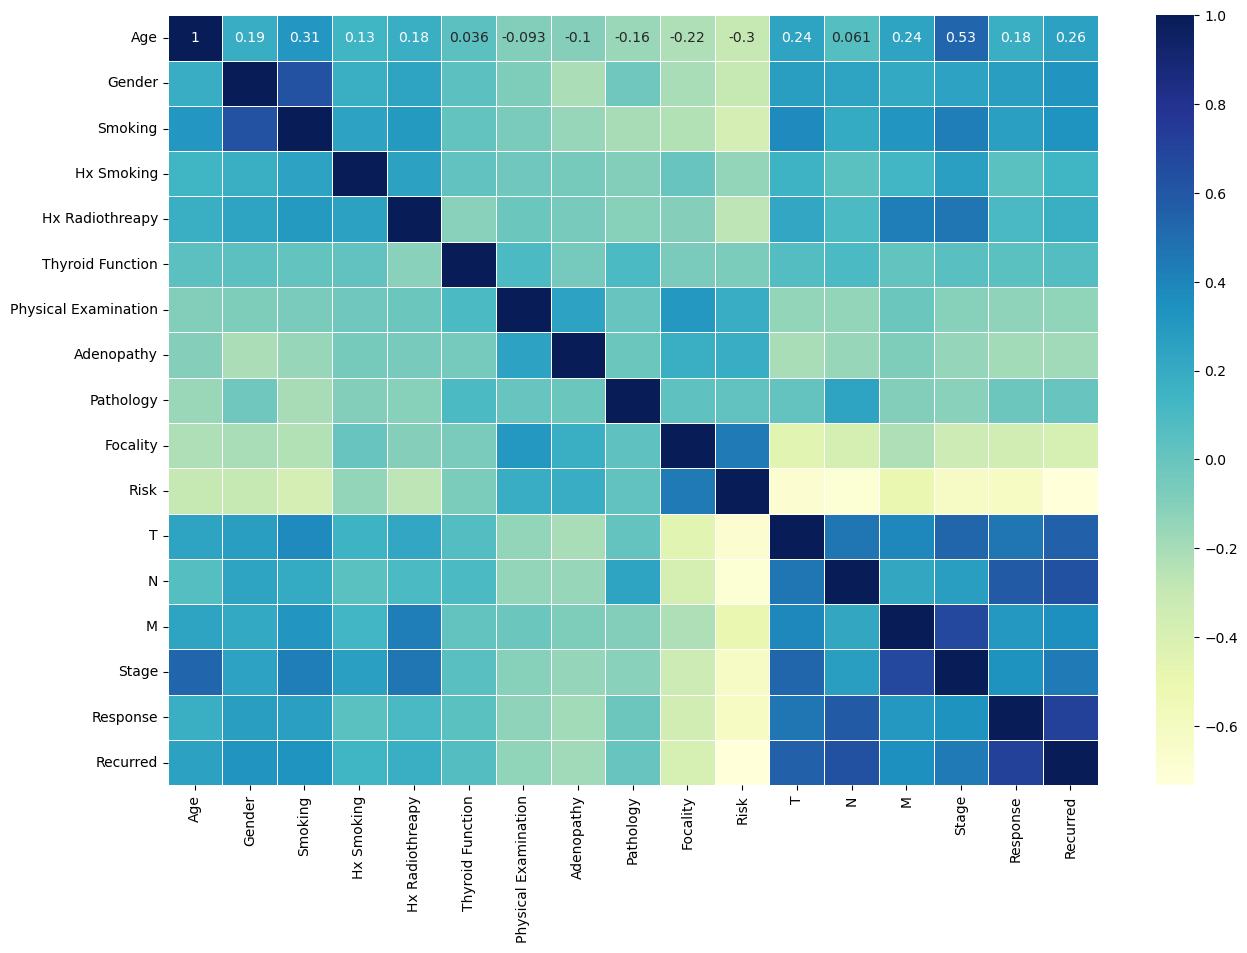

In [12]:
corr_matrix = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix,
           annot=True,
           linewidths=0.5,
           cmap='YlGnBu');

> As we can see, the independent variables that appear to have the greatest impact on the dependent variable are **T**, **N** and **Response**.

## 4. Modeling

### 4.1. Model Choices

In this project we are going to implement six different classification models:

1. **KNN (K-Nearest Neighbors)**
   * KNN is a simple and versatile algorithm for classification tasks
   * It can capture complex patterns in the data
2. **Logistic Regression**
   * Logistic Regression is a classic and widely used model for binary classification problems
   * It provides a probabilistic interpretation of the relationship between independent variables and the dependent variable
5. **Random Forest**
   * Random Forest is an ensemble algorithm that combines multiple decision trees to improve accuracy and reduce overfitting
   * It is robust against outliers and missing data
7. **Support Vector Machine (SVM)**
   * SVM has good generalization capabilities and is resistant to overfitting
9. **Decision Trees**
    * They can handle numerical and categorical data without extensive preprocessing
11. **XGBoost**
    * XGBoost is an optimized implementation of gradient-boosting algorithms
    * It provides high accuracy and speed in predictions

In [13]:
X = df.drop('Recurred', axis=1) 
y = df.Recurred

X_train, X_test, y_train, y_test = train_test_split(X, # independent variables 
                                                    y, # dependent variable
                                                    test_size = 0.2,
                                                    random_state=42)

## Model Comparison

In [14]:
# Put models in a dictionary
models = {"KNN": KNeighborsClassifier(),
          "Logistic Regression": LogisticRegression(), 
          "Random Forest": RandomForestClassifier(),
          "Support Vector Machine": SVC(),
          "Decision Trees": DecisionTreeClassifier(),
          "XGBoost": GradientBoostingClassifier()}

# Create function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data
    X_test : testing data
    y_train : labels assosciated with training data
    y_test : labels assosciated with test data
    """
    # Random seed for reproducible results
    np.random.seed(42)
    # Make a list to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = round(model.score(X_test, y_test),4)
    return model_scores

model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)


# Convertir el diccionario en un DataFrame de pandas
scores_df = pd.DataFrame(list(model_scores.items()), columns=['Modelo', 'Precisión'])

from tabulate import tabulate
# Formatear y mostrar el DataFrame usando tabulate
print(tabulate(scores_df, headers='keys', tablefmt='pretty', showindex=False))

+------------------------+-----------+
|         Modelo         | Precisión |
+------------------------+-----------+
|          KNN           |  0.9091   |
|  Logistic Regression   |  0.9351   |
|     Random Forest      |   0.987   |
| Support Vector Machine |  0.9351   |
|     Decision Trees     |  0.9351   |
|        XGBoost         |   0.974   |
+------------------------+-----------+


> Now, we have six different classifier, between these we gonna select three better to tuning, this models were **Logistic Regression**, **Random Forest**, **Decision Trees** and **XGBoost**

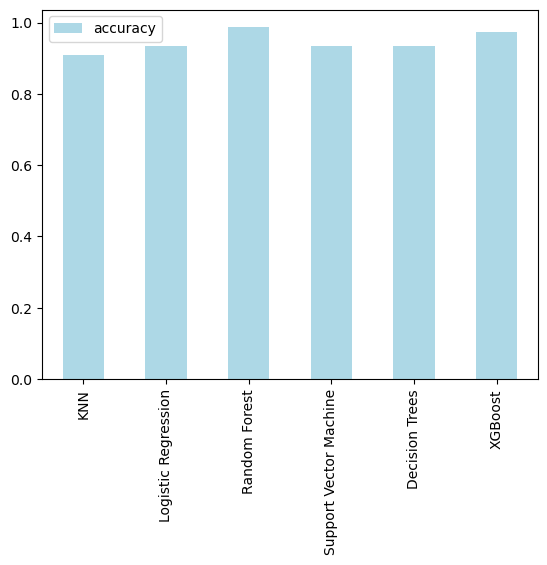

In [15]:
model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.T.plot.bar(color='lightblue');

## Hyperparameter tuning (RadomizedSearchCV) and cross-validation

In [16]:
# Different LogisticRegression hyperparameters
log_reg_grid = {
    "C": np.logspace(-4, 4, 20),
    "solver": ["liblinear"],
    "max_iter": [100, 500, 1000]
}

# Different RandomForestClassifier hyperparameters
rf_grid = {
    "n_estimators": np.arange(10, 1000, 50),
    "max_depth": [None, 3, 5, 10, 20, 30],
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(1, 20, 2),
    "bootstrap": [True, False]
}

# Different DecisionTreeClassifier hyperparameters
dt_grid = {
    "max_depth": [None, 2, 3, 5, 10, 20],
    "min_samples_split": np.arange(2, 15, 2),
    "min_samples_leaf": np.arange(1, 50, 5),
    "criterion": ["gini", "entropy"]
}

# Different XGBoostClassifier hyperparameters
gbc_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.7, 1.0],
    'max_features': ['sqrt', 'log2']
}

In [17]:
%%time 

# Configuración de RandomizedSearchCV para LogisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True,
                                n_jobs=-1)

# Configuración de RandomizedSearchCV para RandomForestClassifier
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True,
                           n_jobs=-1)

# Configuración de RandomizedSearchCV para DecisionTreeClassifier
rs_dt = RandomizedSearchCV(DecisionTreeClassifier(),
                           param_distributions=dt_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True,
                           n_jobs=-1)

# Configuración de RandomizedSearchCV para XGBoostClassifier
rs_gbc = RandomizedSearchCV(GradientBoostingClassifier(),
                            param_distributions=gbc_grid,
                            cv=5,
                            n_iter=20,
                            verbose=True,
                            n_jobs=-1)

# Setup random seed
np.random.seed(42)
rs_log_reg.fit(X_train, y_train);
rs_rf.fit(X_train, y_train);
rs_dt.fit(X_train, y_train);
rs_gbc.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: total: 6.61 s
Wall time: 34.9 s


In [18]:
np.random.seed(42)
scores = {
    "Logistic Regression": rs_log_reg.best_estimator_.score(X_test, y_test),
    "Random Forest": rs_rf.best_estimator_.score(X_test, y_test),
    "Decision Tree": rs_dt.best_estimator_.score(X_test, y_test),
    "Gradient Boosting": rs_gbc.best_estimator_.score(X_test, y_test)
}

table = []
for model, score in scores.items():
    table.append([model, score])

print(tabulate(table, headers=["Model", "Score"], tablefmt="pretty"))

+---------------------+-------------------+
|        Model        |       Score       |
+---------------------+-------------------+
| Logistic Regression | 0.935064935064935 |
|    Random Forest    | 0.974025974025974 |
|    Decision Tree    | 0.948051948051948 |
|  Gradient Boosting  | 0.987012987012987 |
+---------------------+-------------------+


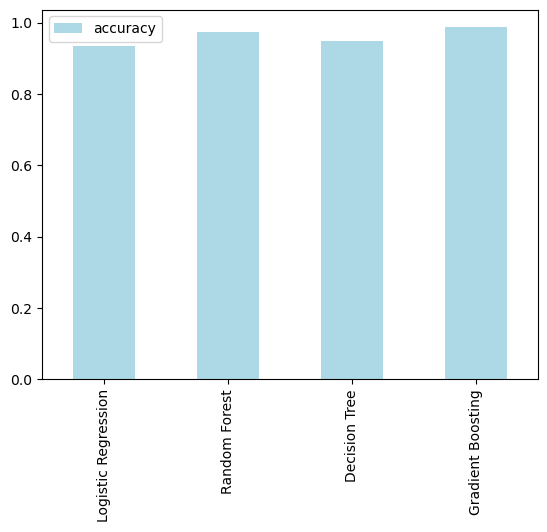

In [19]:
model_compare = pd.DataFrame(scores, index=['accuracy'])
model_compare.T.plot.bar(color='lightblue');

> Now, we really sure that the best model is Gradient Boosting, therefore, we tuning the model with GridSearchCV to see if this became better

## Tuning a model with GridSearchCV

In [20]:
%%time
np.random.seed(42)
# Different XGBoostClassifier hyperparameters
gbc_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.7, 1.0],
    'max_features': ['sqrt', 'log2']
}

gs_gbc = GridSearchCV(GradientBoostingClassifier(),
                          param_grid=gbc_grid,
                          cv=5,
                          verbose=True)

gs_gbc.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
CPU times: total: 10min 25s
Wall time: 10min 38s


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.5, 0.7, 1.0]},
             verbose=True)

In [21]:
gs_gbc.score(X_test, y_test)

0.987012987012987

## Evaluation a classification model 
* ROC curve and AUC score - [`RocCurveDisplay()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html) 
     `sklearn.metrics.RocCurveDisplay()`.
* Confusion matrix - [`confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
* Classification report - [`classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
* Precision - [`precision_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)
* Recall - [`recall_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)
* F1-score - [`f1_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)

### ROC Curve and AUC Scores

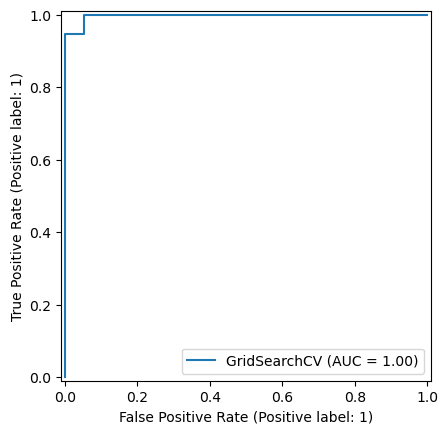

In [22]:
# from_estimator() = use a model to plot ROC curve on data
RocCurveDisplay.from_estimator(estimator=gs_gbc, 
                               X=X_test, 
                               y=y_test); 

> An AUC (Area Under the Curve) of 1.0 indicates that the model has perfect performance in distinguishing between positive and negative classes. This means that the model correctly classifies all instances without making any errors. However, it can be an indication of overfitting. This occurs when the model has learned the characteristics of the training dataset too well, including the noise, and may not generalize well to new and unseen data.

### Confusion matrix

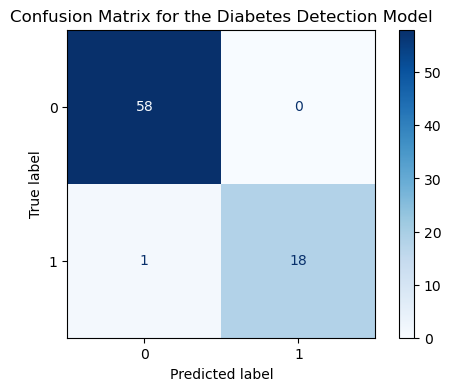

In [23]:
y_preds = gs_gbc.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_preds)
class_names = unique_labels(y_test, y_preds)  # Get unique class labels

# Change figure size and increase dpi for better resolution
fig, ax = plt.subplots(figsize=(6, 4), dpi=100)

# Choose a colormap for visualization (e.g., 'viridis', 'plasma', 'coolwarm')
cmap = 'Blues'

# Create ConfusionMatrixDisplay object (passing class labels)
display = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)

# Customize color scale using the "cmap" parameter
display.plot(ax=ax, cmap=cmap)

# Set the plot title using the axes object
ax.set(title='Confusion Matrix for the Diabetes Detection Model')

# Remove gridlines
ax.grid(False)  # Turn off gridlines

plt.show()

### Classification report

In [24]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        58
           1       1.00      0.95      0.97        19

    accuracy                           0.99        77
   macro avg       0.99      0.97      0.98        77
weighted avg       0.99      0.99      0.99        77



* **High Precision and Recall:** The model has high precision and recall for both classes, with particularly notable perfect precision for the positive class (1.00) and perfect recall for the negative class (1.00). This indicates that the model is very reliable in its predictions and rarely makes errors.
* **High F1-Score:** The high F1-scores for both classes (0.99 for the negative class and 0.97 for the positive class) indicate that the model maintains a good balance between precision and recall.
* **Consistent Performance:** The macro and weighted averages indicate consistent and solid performance across both classes, which is especially important in cases of class imbalance.

In [25]:
#check best hiperparameters
gs_gbc.best_params_

{'learning_rate': 0.2,
 'max_depth': 7,
 'max_features': 'sqrt',
 'n_estimators': 100,
 'subsample': 1.0}

Now we init best model with best hyperparameters

In [26]:
np.random.seed(42)

model_gbc = GradientBoostingClassifier(learning_rate=0.2,
                                       max_depth = 7,
                                       max_features= 'sqrt',
                                       n_estimators=100,
                                       subsample=1.0)

model_gbc.fit(X_train, y_train)

model_gbc.score(X_test, y_test)

0.987012987012987

### Cross validation metrics
> The previous results were very good, which raises the question of whether the model might be overfitted. Therefore, an analysis of the metrics will be performed using cross-validation to obtain a more robust value.

In [27]:
# Cross-validated accuracy score
cv_acc = cross_val_score(model_gbc,
                         X,
                         y,
                         cv=10, # 5-fold cross-validation
                         scoring="accuracy") # accuracy as scoring
cv_acc = np.mean(cv_acc)
cv_acc

0.9109986504723345

In [28]:
# Cross-validated precision score
cv_precision = np.mean(cross_val_score(model_gbc,
                                       X,
                                       y,
                                       cv=10, # 5-fold cross-validation
                                       scoring="precision")) # precision as scoring
cv_precision

0.9108333333333334

In [29]:
# Cross-validated recall score
cv_recall = np.mean(cross_val_score(model_gbc,
                                    X,
                                    y,
                                    cv=10, # 5-fold cross-validation
                                    scoring="recall")) # recall as scoring
cv_recall

0.8809090909090909

In [30]:
# Cross-validated F1 score
cv_f1 = np.mean(cross_val_score(model_gbc,
                                X,
                                y,
                                cv=10, # 5-fold cross-validation
                                scoring="f1")) # f1 as scoring
cv_f1

0.8758954495858857

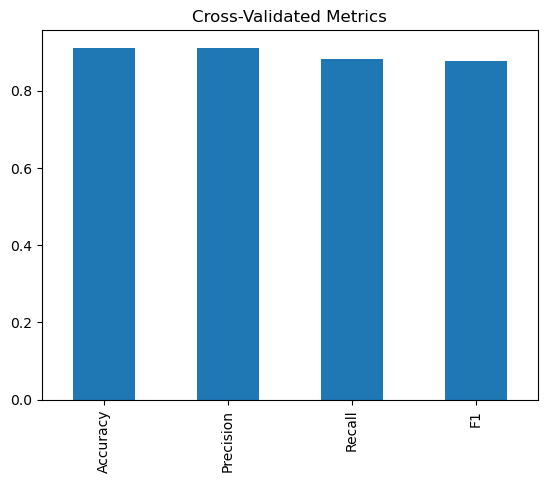

In [31]:
# Visualizing cross-validated metrics
cv_metrics = pd.DataFrame({"Accuracy": cv_acc,
                            "Precision": cv_precision,
                            "Recall": cv_recall,
                            "F1": cv_f1},
                            index=[0])
cv_metrics.T.plot.bar(title="Cross-Validated Metrics", legend=False);

## Feature importance

In [32]:
model_gbc.feature_importances_

array([6.53629075e-02, 1.26481991e-02, 3.34135516e-03, 2.33058339e-03,
       9.17238460e-06, 1.59689248e-02, 2.20706224e-02, 8.38931416e-02,
       1.90548273e-02, 5.32065123e-02, 1.41244063e-01, 1.72085030e-01,
       5.74914528e-02, 9.23418927e-03, 3.64208021e-02, 3.05638217e-01])

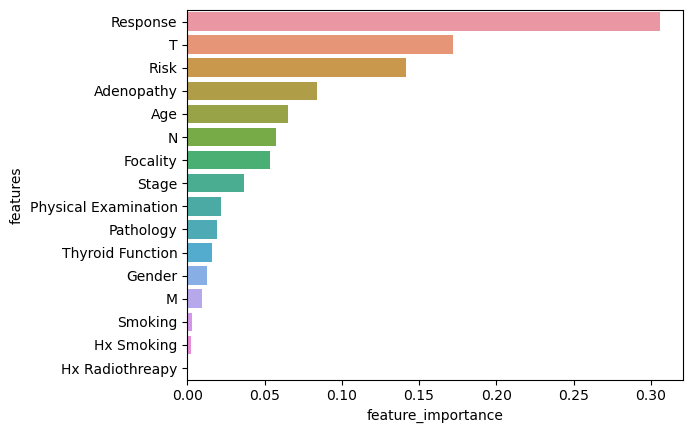

In [33]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importance": importances})
          .sort_values("feature_importance", ascending=False)
          .reset_index(drop=True))
    
    sns.barplot(x="feature_importance",
                y="features",
                data=df[:n],
                orient="h")
    
plot_features(X_train.columns, model_gbc.feature_importances_)

> With this last image, we can identify the features that contribute the most to the resulting classification model. We observe that the variables with the highest correlation in the correlation matrix generated during the data analysis stage are also the ones showing the greatest importance in the model.

## Conclusions

> For the current model, a minimum precision of **95%** was sought due to its medical use, achieving a precision of **99%** with the **XGBoost model** trained after hyperparameter analysis.